Setup & Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import cv2
import pandas as pd

from tqdm import tqdm
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Dataset Locations (RAF-DB)

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET"

train_path = os.path.join(DATA_DIR, "train")
test_path  = os.path.join(DATA_DIR, "test")

print("Train Path:", train_path)
print("Test Path:", test_path)

Train Path: /content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET/train
Test Path: /content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET/test


Transformations

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

Load Dataset

In [ ]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_path,  transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Classes:", train_dataset.classes)
print("Mapping:", train_dataset.class_to_idx)

Classes: ['1', '2', '3', '4', '5', '6', '7']
Mapping: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


CBAM Attention Blocks

In [ ]:
# ----------------- CBAM ATTENTION -----------------

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels//reduction, 1)
        self.fc2 = nn.Conv2d(channels//reduction, channels, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max(x))))
        return self.sigmoid(avg_out + max_out) * x


class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, 7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out,_ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x)) * x


class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.ca = ChannelAttention(channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x))

EECNN-ResNet Architecture (Multi-Scale Fusion)

In [ ]:
class EECNN_ResNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        self.layer1 = nn.Sequential(
            backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool
        )
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.attn = CBAM(512)

        # FC will be created dynamically
        self.fc1 = None
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x4 = self.attn(x4)

        # Dynamically find smallest spatial size
        target_size = x4.shape[-1]

        # Resize all to match the deepest layer
        x2 = F.adaptive_avg_pool2d(x2, (target_size, target_size))
        x3 = F.adaptive_avg_pool2d(x3, (target_size, target_size))

        fused = torch.cat([x2, x3, x4], dim=1)
        fused_flat = fused.view(fused.size(0), -1)

        # ---- dynamic FC initialization ----
        if self.fc1 is None:
            in_features = fused_flat.size(1)
            self.fc1 = nn.Linear(in_features, 512).to(fused.device)

        x = self.fc1(fused_flat)
        x = self.dropout(x)
        return self.fc2(x)

Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EECNN_ResNet(num_classes=7).to(device)

labels = [label for _, label in train_dataset.imgs]
weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


Training Loop

In [ ]:
num_epochs = 30
best_acc = 0

save_path = "/content/drive/MyDrive/Best_Models/eecnn_resnet_best.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):

    # -------- TRAIN --------
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # ---- MIXED PRECISION ----
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # --------------------------

        loss_sum += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    train_losses.append(loss_sum / len(train_loader))
    train_accs.append(train_acc)


    # -------- VALIDATION --------
    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_sum += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total * 100
    val_losses.append(loss_sum / len(test_loader))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"🔥 Saved best model: {best_acc:.2f}%")

    scheduler.step()

Plot Curves

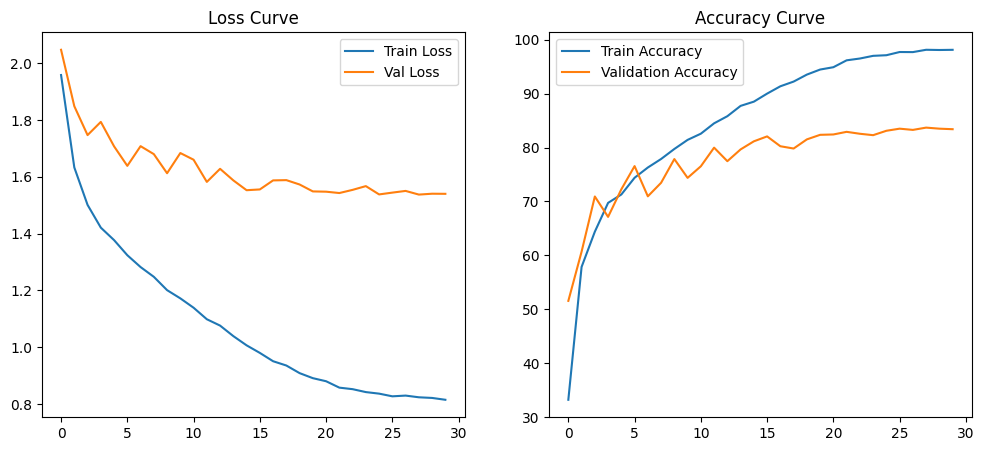

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

Evaluation

In [ ]:
save_path = "/content/drive/MyDrive/Best_Models/eecnn_resnet_best.pth"
model.load_state_dict(torch.load(save_path))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

RuntimeError: Error(s) in loading state_dict for EECNN_ResNet:
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias". 

Prediction Utility

In [ ]:
emotion_map_idx = {
    0: "Surprise",
    1: "Fear",
    2: "Disgust",
    3: "Happiness",
    4: "Sadness",
    5: "Anger",
    6: "Neutral",
}

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    x = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(x)
        _, pred = outputs.max(1)

    class_name = train_dataset.classes[pred.item()]
    return emotion_map_idx[pred.item()]

Show Prediction

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled p

In [ ]:
import mediapipe as mp

mp_face = mp.solutions.face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

def detect_and_crop_face_frame(frame):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = mp_face.process(img_rgb)

    if not results.detections:
        return None

    det = results.detections[0]
    bbox = det.location_data.relative_bounding_box

    h, w, _ = img_rgb.shape
    x  = int(bbox.xmin * w)
    y  = int(bbox.ymin * h)
    ww = int(bbox.width * w)
    hh = int(bbox.height * h)

    pad = 0.1
    x1 = max(0, int(x - ww * pad))
    y1 = max(0, int(y - hh * pad))
    x2 = min(w, int(x + ww * (1 + pad)))
    y2 = min(h, int(y + hh * (1 + pad)))

    face = img_rgb[y1:y2, x1:x2]

    if face.size == 0:
        return None

    return Image.fromarray(face)


ModuleNotFoundError: No module named 'mediapipe'

Face Detection + Cropping

In [ ]:
def show_prediction(img_path):
    face = detect_and_crop_face(img_path)

    if face is None:
        return

    emotion = predict_image(img_path)

    plt.imshow(face)
    plt.axis("off")
    plt.title(f"Predicted Emotion: {emotion}", fontsize=16)
    plt.show()